# **Fraud Detection**

In this experiment, I would like to demonstrate the process of making machine learning model which is able to predict the fraud transactions.

There are 2 major step of this experiment, **feature engineering** and **modeling**

## **1. Feature Engineering**

In the feature engineering process, I will evaluate features and decide whether to use those features or not. After considering it, then I need to fill the missing values, encode categorical features, and perform feature scaling.

### **a. Data Preparation**

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import packages
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [ ]:
# Read the dataset
df_transaction = pd.read_csv("/content/drive/MyDrive/Study/Computer Science/Project/Telkomsel Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/train_transaction.csv")
df_identity = pd.read_csv("/content/drive/MyDrive/Study/Computer Science/Project/Telkomsel Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/train_identity.csv")
df_transaction.shape, df_identity.shape

((590540, 394), (144233, 41))

In [ ]:
# Merge training transaction and identity datasets
df_train = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')
df_train.shape

(590540, 434)

### **b. Feature selection**

**Removing features with many missing values**

In this dataset, there are a lot of features which contain many missing values. So I use the threshold of 50% where if each feature loss its values by 50%, I consider to remove that feature. It is because I think the remaining 50% values will be very difficult to be used to fill other 50% missing values.

I did the action aforementioned because I didn't get enough explanation about the features where most of the features are encoded into the anonymus name to keep the privacy of the dataset provider. I think we can also fill the feature with many missing values if we have the domain expert who understand about that feature.

In [ ]:
# Detecting feature with 80% above of missing values in transaction data
list_feature_with_many_missing_values = []
for feature in tqdm(df_train.columns):
  missing_values = len(df_train[df_train[feature].isna()])
  missing_proportion = missing_values/len(df_train)
  if missing_proportion > 0.5:
    list_feature_with_many_missing_values.append(feature)

# Drop features with many missing values
df_train = df_train.drop(columns=list_feature_with_many_missing_values, axis=1)
print(f"\nTotal features removed = {len(list_feature_with_many_missing_values)}")

100%|██████████| 434/434 [03:32<00:00,  2.04it/s]



Total features removed = 214


**Removing features which have low significance level**

During this process, I filter the features whether they have significane value with the label data or not. I perform ANOVA to evaluate continuous & categorical (label) and Chi Square to evaluate both categorical features.

In [ ]:
# Making copy for dataset
df_train_1 = df_train.copy()

In [ ]:
# Encode categorical features values to be numeric
categorical_features = df_train_1.select_dtypes(include='object').columns

# Fit and transform with OrdinalEncoder
encoder = OrdinalEncoder()
df_train_1[categorical_features] = encoder.fit_transform(df_train_1[categorical_features])

In [ ]:
from sklearn.feature_selection import f_classif, chi2
# Remove features with low significance value
list_remove_cols = []
for feature in df_train_1.columns:
  if feature == 'isFraud':
    continue
  temp = df_train_1[df_train_1[feature].notna()][feature]
  label = df_train_1[df_train_1[feature].notna()]["isFraud"]
  if feature in categorical_features:
    # chi square
    _, p_value = chi2(
        temp.values.reshape(temp.shape[0], 1),
        label.values.reshape(label.shape[0], 1)
    )
  else:
    # anova
    _, p_value = f_classif(
        temp.values.reshape(temp.shape[0], 1),
        label.values.reshape(label.shape[0], 1)
    )
  print(f"P Value {feature} = {p_value[0]}")
  if p_value[0] > 0.05:
    # If the feature has p value above 0.05, it means that feature has
    # low significance level, so we can choose to remove it
    list_remove_cols.append(feature)

df_train_1 = df_train_1.drop(columns=list_remove_cols, axis=1)
print(f"Removed {len(list_remove_cols)} features !")

P Value Unnamed: 0 = 1.3377066812683043e-27
P Value TransactionID = 1.3377066948030884e-27
P Value TransactionDT = 7.523524449430577e-24
P Value TransactionAmt = 3.3434624582282236e-18
P Value ProductCD = 0.0
P Value card1 = 1.041583820259324e-25
P Value card2 = 0.009774516809798186
P Value card3 = 0.0
P Value card4 = 0.22757017096355095
P Value card5 = 7.217649738437605e-146
P Value card6 = 3.941862038196414e-142
P Value addr1 = 5.037154291060864e-05
P Value addr2 = 1.8885127235824542e-107
P Value P_emaildomain = 0.0
P Value C1 = 4.350244257702197e-122
P Value C2 = 3.89492119744403e-180
P Value C3 = 1.5118373742284574e-07
P Value C4 = 1.2853500293154332e-120
P Value C5 = 1.534578299791619e-123
P Value C6 = 4.1699822245630536e-58
P Value C7 = 6.852262075253182e-104
P Value C8 = 9.726147579736948e-135
P Value C9 = 3.6402609873383874e-131
P Value C10 = 1.3228056995000955e-105
P Value C11 = 4.7601601548262015e-99
P Value C12 = 8.130980346163156e-133
P Value C13 = 1.0772039391607685e-17
P 

In [ ]:
# Remove low significance features in original df_train
df_train = df_train.drop(columns=list_remove_cols, axis=1)

### **c. Handling missing values**

After getting ready with the only significance features, then we can fill missing values on each feature. Until this process, there are features which contain large amount of missing values (more than 50 thousands values). So, I consider to focus more on those features.

In [ ]:
list_features_many_missing_values = list(df_train.isnull().sum()[df_train.isnull().sum().values > 50000].index)
print(f"Total number of features with more than 50 thousands missing values = {len(list_features_many_missing_values)}")

Total number of features with more than 50 thousands missing values = 103


**Address 1 and 2**

Based on the dataset description on kaggle, I found that these features tend to have relationship with C1-C14 columns, where C columns represent the counting of how many addresses are found in the payment transactions. So I tried to create simple grouping of address 1 and 2 with the C columns.

In [ ]:
addr1_grouping = df_train[[
    "C1", "C2", "C3", "C4",
    "C5", "C6", "C7", "C8",
    "C9", "C10", "C11", "C12",
    "C13", "C14", "addr1"]].groupby(by=["addr1"]).mean()
addr2_grouping = df_train[[
    "C1", "C2", "C3", "C4",
    "C5", "C6", "C7", "C8",
    "C9", "C10", "C11", "C12",
    "C13", "C14", "addr2"]].groupby(by=["addr2"]).mean()
mean_addr1 = np.mean(addr1_grouping.values, axis=1)
mean_addr2 = np.mean(addr2_grouping.values, axis=1)
addr1_grouping["mean_value_c1_c14"] = mean_addr1
addr2_grouping["mean_value_c1_c14"] = mean_addr2

# Print sample dataframe
addr1_grouping

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,mean_value_c1_c14
addr1,,,,,,,,,,,,,,,
100.0,1.269231,1.730769,0.0,1.076923,0.000000,1.076923,1.076923,1.615385,0.000000,1.153846,1.076923,1.076923,2.346154,1.153846,1.046703
101.0,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.785714
102.0,1.384615,3.076923,0.0,1.000000,0.000000,1.000000,1.000000,1.153846,0.000000,1.076923,1.692308,1.692308,2.153846,0.923077,1.153846
104.0,2.750000,2.375000,0.0,0.000000,0.375000,2.375000,0.000000,0.000000,1.875000,0.000000,1.625000,0.125000,16.875000,2.500000,2.205357
105.0,5.666667,7.666667,0.0,0.000000,1.666667,5.666667,0.000000,0.000000,4.666667,0.000000,6.333333,0.333333,16.333333,5.000000,3.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530.0,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.785714
531.0,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.785714
535.0,1.500000,1.500000,0.0,1.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.785714


Based on the grouping dataframe above, I can have the insight that I can use mean value of c1-c14 in order to fill the missing values of addr1.

In [ ]:
def fill_addr_values(df_train, addr_type):
  print(f"Processing {addr_type}")
  # Construct grouping based on mean value of C1 to C14
  addr_grouping_df = df_train[[
    "C1", "C2", "C3", "C4",
    "C5", "C6", "C7", "C8",
    "C9", "C10", "C11", "C12",
    "C13", "C14", addr_type]].groupby(by=[addr_type]).mean()
  mean_addr = np.mean(addr_grouping_df.values, axis=1)
  addr_grouping_df["mean_value_c1_c14"] = mean_addr

  # Get data where there are addr missing values
  addr_null_df = df_train[df_train[addr_type].isna()][
      [
        "C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14"
      ]
  ]

  for idx in tqdm(range(len(addr_null_df))):
    # Calculate mean value from the non-nan addr1
    current_mean = np.mean(addr_null_df.values[idx])
    mean_difference = abs(current_mean-addr_grouping_df["mean_value_c1_c14"].values)
    closest_mean_val = np.min(mean_difference)
    get_index_closest_mean_val = np.where(mean_difference == closest_mean_val)[0][0]
    get_addr_val = addr_grouping_df.index[get_index_closest_mean_val]
    # Replace value in df train
    get_real_idx_from_addr_null = addr_null_df.index[idx]
    df_train[addr_type].iloc[get_real_idx_from_addr_null] = get_addr_val

In [ ]:
fill_addr_values(df_train, "addr1")
fill_addr_values(df_train, "addr2")

Processing addr1


100%|██████████| 65706/65706 [02:06<00:00, 518.57it/s]


Processing addr2


100%|██████████| 65706/65706 [01:57<00:00, 557.68it/s]


**P Email Domain**

In this process, P email domain is basically the email address used by a person to perform transaction. Since there is no detail information about this feature with the others, so I used my intuition that this email domain tend to have the relationship with the amount of transaction (it is because there are many scammer outside there used specific domain email for conducting fraud transaction). To verify my idea, I calculate the P value between these features.

In [ ]:
email_encoder = OrdinalEncoder()
non_null_p_email_domain = df_train[df_train["P_emaildomain"].notna()]
non_null_p_email_domain["P_emaildomain"] = email_encoder.fit_transform(
    non_null_p_email_domain["P_emaildomain"].values.reshape(non_null_p_email_domain["P_emaildomain"].shape[0], 1)
)

# Apply anova to evaluate p email domain with transaction amount
_, p_value = f_classif(
    non_null_p_email_domain["P_emaildomain"].values.reshape(non_null_p_email_domain["P_emaildomain"].shape[0], 1),
    non_null_p_email_domain["TransactionAmt"].values.reshape(non_null_p_email_domain["TransactionAmt"].shape[0], 1)
)
p_value[0]

np.float64(0.0)

Based on the p value above, I got the result near to 0, which means email domain has significance level with respect to transaction amount. So I used the same technique like filling address.

In [ ]:
def fill_p_email_domain(df_train, non_null_p_email_domain):
  grouping_email_df = df_train[[
      "P_emaildomain", "TransactionAmt"
  ]].groupby(by=["P_emaildomain"]).mean()
  # Get data where there are addr missing values
  null_email_domain = df_train[df_train["P_emaildomain"].isna()][["TransactionAmt"]]

  for idx in tqdm(range(len(null_email_domain))):
    mean_value = null_email_domain["TransactionAmt"].values[idx]
    mean_difference = abs(mean_value-grouping_email_df["TransactionAmt"].values)
    closest_mean_val = np.min(mean_difference)
    get_index_closest_mean_val = np.where(mean_difference == closest_mean_val)[0][0]
    get_p_email_val = grouping_email_df.index[get_index_closest_mean_val]
    # Replace value in df train
    get_real_idx_email_domain = null_email_domain.index[idx]
    df_train["P_emaildomain"].iloc[get_real_idx_email_domain] = get_p_email_val

In [ ]:
fill_p_email_domain(df_train, non_null_p_email_domain)

100%|██████████| 94456/94456 [08:52<00:00, 177.48it/s]


**V Features**

Based on the dataset documentation, I didn't find any detail explanation about all of these features and how they will relate with the other features. So, I decided to fill these missing values with either median or mean.

In [ ]:
# Select V features
v_features = [col for col in df_train.columns if col.startswith("V")]
df_train[v_features].describe()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V308,V309,V310,V312,V313,V314,V315,V316,V317,V320
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,1.023826,1.041150,0.846456,0.876991,1.024080,1.038407,1.014602,1.021888,0.463915,0.252457,...,230.408498,10.995763,118.193256,39.173114,21.305592,43.226087,26.749372,109.816313,247.601710,42.072278
std,0.175789,0.236202,0.319475,0.345501,0.175282,0.224238,0.135791,0.165623,0.378621,0.466946,...,3021.893722,116.253107,352.979909,172.126681,95.804974,173.443984,116.734202,2270.010192,3980.002546,473.494534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.846456,0.876991,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.846456,0.876991,1.000000,1.000000,1.000000,1.000000,0.463915,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.463915,0.000000,...,35.965801,0.000000,107.949997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,5.000000,...,108800.000000,55125.000000,55125.000000,55125.000000,4817.470215,7519.870117,4817.470215,93736.000000,134021.000000,104060.000000


To see whether I need to fill missing values with mean or median, I calculate the skewness score for both features. This will be the same as we evaluate it using distribution plot, but due to the massive amount of V features (more than 300 features), so I just calculate the skewness score.

If the feature high skewness level, I decided to use median. It is because if we use mean for this kind of feature, we will fill the missing value with in appropriate value (tend to fill with outliers).

In [ ]:
for feature in tqdm(df_train[v_features].columns):
  if (
      df_train[feature].skew() > 0.5
      or df_train[feature].skew() < -0.5
  ):
    # Consider using median becuase of skewness
    median = df_train[feature].median()
    df_train[feature] = df_train[feature].fillna(median)
  else:
    # Consider using mean becuase of the distribution closes to normal distribution
    mean = df_train[feature].mean()
    df_train[feature] = df_train[feature].fillna(mean)

100%|██████████| 160/160 [00:03<00:00, 52.68it/s]


**D Features**

For these D features, I did the same technique like V features, but due to the small number of features, I could visualize it through distribution plot to see the skewness level.

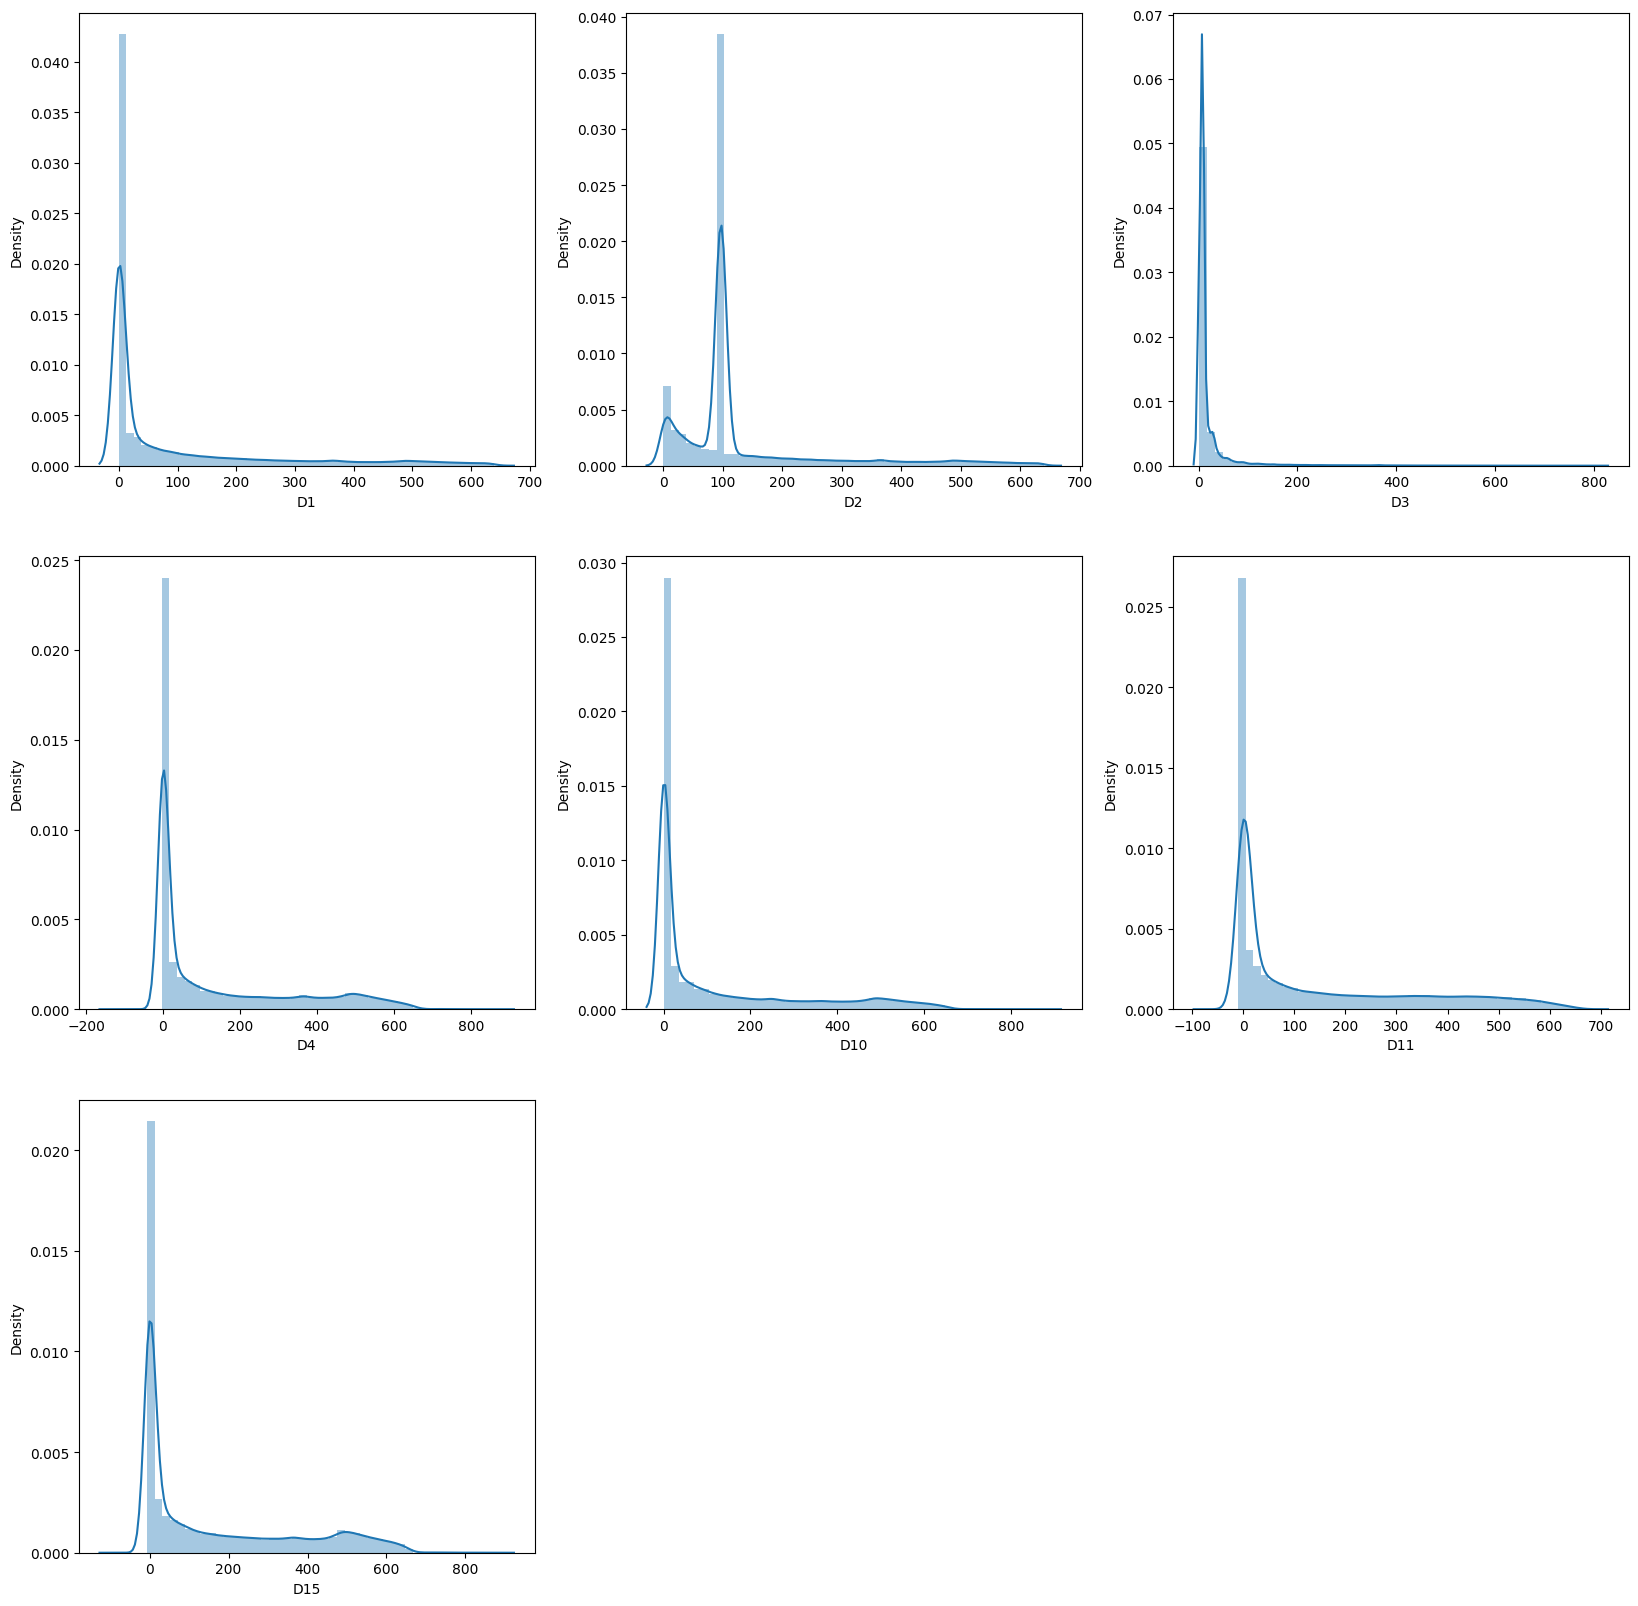

In [ ]:
df_d = df_train[[
    "D1", "D2", "D3", "D4", "D10", "D11", "D15"
]]
# Plot density
plt.figure(figsize=(20,20))
idx = 1
for feature in df_d.columns:
  plt.subplot(3,3,idx)
  sns.distplot(df_d[feature])
  idx += 1

In [ ]:
for feature in tqdm(df_d.columns):
  median = df_d[feature].median()
  df_train[feature] = df_train[feature].fillna(median)

100%|██████████| 7/7 [00:00<00:00, 79.32it/s]


**M Features**

For M features, I didn't get enough information too about how these features correlated with others. Based on that, I just filled these missing values with the most frequent values.

In [ ]:
df_m = df_train[["M2", "M3", "M4", "M6"]]
df_m

,M2,M3,M4,M6
0,T,T,M2,T
1,NaN,NaN,M0,T
2,T,T,M0,F
3,NaN,NaN,M0,F
4,NaN,NaN,NaN,NaN
...,...,...,...,...
590535,T,T,M0,F
590536,F,F,M0,T
590537,F,F,NaN,T
590538,T,T,M0,T


In [ ]:
for feature in tqdm(df_m.columns):
  most_frequent = df_m[feature].mode().values[0]
  df_train[feature] = df_train[feature].fillna(str(most_frequent))

100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


**The remaining missing values**

Based on the exploration below, we can see the other missing values are very few, so to save the time, I just drop these values because the proportion of these rows is very small compared to our entire dataset.

In [ ]:
# Check the remaining missing values
df_train.isnull().sum()[df_train.isnull().sum().values != 0]

,0
card2,8933
card3,1565
card5,4259
card6,1571


In [ ]:
# Drop the other remaining missing values
df_train = df_train.dropna()
df_train.shape

(579507, 201)

In [ ]:
# Drop unnecessary features
df_train = df_train.drop(columns=[
    "Unnamed: 0.2",
    "Unnamed: 0.1",
    "Unnamed: 0",
    "TransactionID",
    "TransactionDT"
], axis=1)

In [ ]:
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,...,V308,V309,V310,V312,V313,V314,V315,V316,V317,V320
1,0,29.0,W,2755,404.0,150.0,102.0,credit,325.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59.0,W,4663,490.0,150.0,166.0,debit,330.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,50.0,W,18132,567.0,150.0,117.0,debit,476.0,87.0,...,925.0,0.0,354.0,135.0,0.0,0.0,0.0,50.0,1404.0,0.0
4,0,50.0,H,4497,514.0,150.0,102.0,credit,420.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,49.0,W,5937,555.0,150.0,226.0,debit,272.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Embedding**

For categorical features, I used embedding method to create new vector which can represent each categorical values. I used this because on feature email domain, there are more than 50 unique values, so I think embedding method will be suitable for it.

In [ ]:
label_data = df_train["isFraud"].values
df_train = df_train.drop(columns=["isFraud", "Unnamed: 0"], axis=1)

In [ ]:
def encode_categorical_data(df_train):
  categorical_data = df_train[["ProductCD", "card6", "P_emaildomain", "M2", "M3",	"M4",	"M6"]]
  encoder = OrdinalEncoder()
  encoded_categorical = encoder.fit_transform(categorical_data.values)

  return encoded_categorical, encoder

def embedding(encoded_categorical):
  encoded_categorical = torch.from_numpy(encoded_categorical).to(torch.int64)

  product_embedding = nn.Embedding(5, 3)
  card6_embedding = nn.Embedding(4, 3)
  email_embedding = nn.Embedding(59, 10)
  m2_embedding = nn.Embedding(2, 2)
  m3_embedding = nn.Embedding(2, 2)
  m4_embedding = nn.Embedding(3, 2)
  m6_embedding = nn.Embedding(3, 2)

  product_embedded = product_embedding(encoded_categorical[:, 0])
  card6_embedded = card6_embedding(encoded_categorical[:, 1])
  email_embedded = email_embedding(encoded_categorical[:, 2])
  m2_embedded = m2_embedding(encoded_categorical[:, 3])
  m3_embedded = m3_embedding(encoded_categorical[:, 4])
  m4_embedded = m4_embedding(encoded_categorical[:, 5])
  m6_embedded = m6_embedding(encoded_categorical[:, 6])

  embedding_result = torch.cat([
      product_embedded,
      card6_embedded,
      email_embedded,
      m2_embedded,
      m3_embedded,
      m4_embedded,
      m6_embedded
  ], dim=1)

  embedding_result = embedding_result.detach().numpy()

  return embedding_result


In [ ]:
encoded_categorical, _ = encode_categorical_data(df_train)

embedding_result = embedding(encoded_categorical)
embedding_result.shape

(579507, 24)

**Scaling Numerical Features**

For continuous features, I used min max scaler to scale the data into 0 to 1.

In [ ]:
numerical_features = df_train.select_dtypes(include=["float64", "int64"])
numerical_features

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,...,V308,V309,V310,V312,V313,V314,V315,V316,V317,V320
0,29.000,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,59.000,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,50.000,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,0.0,...,925.000000,0.0,354.0,135.0,0.0,0.0,0.0,50.0,1404.0,0.000000
3,50.000,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,49.000,5937,555.0,150.0,226.0,272.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579502,67.505,5812,408.0,185.0,224.0,195.0,28.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
579503,39.500,10444,225.0,150.0,224.0,204.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
579504,30.950,12037,595.0,150.0,224.0,231.0,87.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
579505,117.000,7826,481.0,150.0,224.0,387.0,87.0,1.0,1.0,0.0,...,117.000000,117.0,669.5,117.0,317.5,669.5,317.5,0.0,2234.0,0.000000


In [ ]:
def scaling_numerical_features(df_train):
  numerical_features = df_train.select_dtypes(include=["float64", "int64"])
  scaler = MinMaxScaler()
  scaled_numerical = scaler.fit_transform(numerical_features.values)
  return scaled_numerical, scaler

In [ ]:
scaled_numerical, _ = scaling_numerical_features(df_train)
scaled_numerical.shape

(579507, 188)

In [ ]:
final_train_data = np.concatenate([scaled_numerical, embedding_result], axis=1)

**Saving the final data**

In [ ]:
np.save("/content/drive/MyDrive/Study/Computer Science/Project/Telkomsel Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/final_train_data.npy", final_train_data)
np.save("/content/drive/MyDrive/Study/Computer Science/Project/Telkomsel Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/label_data.npy", label_data)

## **Modeling**

In [4]:
final_train_data = np.load("/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/final_train_data.npy")
label_data = np.load("/content/drive/MyDrive/Study/Computer_Science/Project/Telkomsel_Recruitment/fraud-detection-telkomsel-recruitment/ieee-fraud-detection/label_data.npy")
final_train_data.shape, label_data.shape

((579507, 212), (579507,))

In [50]:
x_train, x_test, y_train, y_test = train_test_split(final_train_data, label_data, test_size=0.10)

In [51]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score

**Random Forest Classifier**

In [52]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
prediction_RFC = rfc.predict(x_test)
print(classification_report(y_test, prediction_RFC))
print(f"AUC ROC Score = {roc_auc_score(y_test, prediction_RFC)}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     55973
           1       0.89      0.49      0.63      1978

    accuracy                           0.98     57951
   macro avg       0.94      0.74      0.81     57951
weighted avg       0.98      0.98      0.98     57951

AUC ROC Score = 0.7424004237417878


**Decision Tree Classifier**

In [46]:
DTC = DecisionTreeClassifier()
DTC.fit(x_train, y_train)
prediction_DTC = DTC.predict(x_test)
print(classification_report(y_test, prediction_DTC))
print(f"AUC ROC Score = {roc_auc_score(y_test, prediction_DTC)}")

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     84025
           1       0.53      0.59      0.56      2902

    accuracy                           0.97     86927
   macro avg       0.76      0.79      0.77     86927
weighted avg       0.97      0.97      0.97     86927

AUC ROC Score = 0.7871479764132749


**Logistic Regression**

In [45]:
LR = LogisticRegression()
LR.fit(x_train, y_train)
prediction_LR = LR.predict(x_test)
print(classification_report(y_test, prediction_LR))
print(f"AUC ROC Score = {roc_auc_score(y_test, prediction_LR)}")

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     84025
           1       0.78      0.13      0.23      2902

    accuracy                           0.97     86927
   macro avg       0.88      0.57      0.61     86927
weighted avg       0.96      0.97      0.96     86927

AUC ROC Score = 0.5656849465767692


**XGB Classifier**

In [ ]:
XGB = XGBClassifier()
XGB.fit(x_train, y_train)
prediction_XGB = XGB.predict(x_test)
print(classification_report(y_test, prediction_XGB))
print(f"AUC ROC Score = {roc_auc_score(y_test, prediction_XGB)}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     83922
           1       0.90      0.47      0.62      3005

    accuracy                           0.98     86927
   macro avg       0.94      0.74      0.81     86927
weighted avg       0.98      0.98      0.98     86927

AUC ROC Score = 0.7361336854232087


# **Conclusion**

The models above showed different results, but the recall was still low. This model building process need to be tuned properly further and I can't do that right now due to the limitation of technical test timeline.

The methods which should do further:

1.   More robust feature engineering with domain expert. We can correctly fill the missing values.
2.   Hyper parameter tuning. Since the dataset quite large, The training time for each model is quite long, so I don't have enough time to tune the models properly.
3. Cross Validation (to validate the model performance with different types of split). I also don't have enough time to do this because of the duration of training process and I must provide the solution for another technical test.

